In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import multiprocessing as mp
from itertools import repeat

import sys
sys.path.insert(0, "../tfspline")

try:
    import model
    import plot
    import sampledata
    import parallel
except ImportError:
    print('No Import')

## Input data
To simplify choice of constants we shift and scale data such that values are in the [0, 1] range. Otherwise we would need to adapt learning rate and similar things. We skip the back-transformation as we would do in production code.

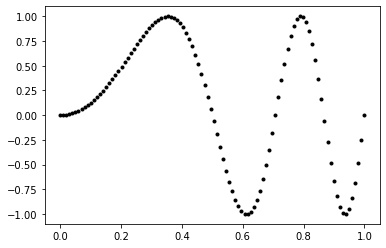

In [5]:
# Generate input data
#data_x = np.linspace(0, 0.5*np.pi, 20)
data_x = np.linspace(0, 1, 100)
#data_y = np.sin(data_x)
data_y = np.sin(data_x**2 * 4 * np.pi)
#[data_x, data_y] = sampledata.rescale_input_data(data_x, data_y)

plt.plot(data_x, data_y, 'k.')

## Spline properties based on Stefan Huber's findings in "Polynomial approximation.ipynb"

### Learning rate

0.1

### Gradient regularization

SGD benefits from regularization while adaptive optimizers (Adam) do not.
However, the regularization does not have any negative effect with adaptive optimizers, so we will leave it on in both cases.

### Input data

Number of points: Increasing the number of points to be approximated regulates the convergence. However, the effect is mild.
Noise / shape of input: Does not affect convergence.

### Optimizers

We limit ourselves to SGD and Adam, as other optimizers fail for high learning rate (0.1) in our application.
SGD: nesterov = true, momentum = 0.95
Adam: beta1 = 0.9

### Polynomial degree

With Adam and SGD after we see best results with polynomial degree 5.

### Number of polynomials
We start with observing the problem using only 2 polynomial pieces since we do not expect the behavior to be fundamentally different to using higher number of polynomial pieces.  
We will then use the findings of this smaller problem and apply them to larger number of segments.

In [3]:
learning_rate_adam = 0.1
learning_rate_sgd = 0.1
gradient_regularization=True
deg=5
n=12
continuity=False
seg_overlap = 0
epochs=50000

## Investigating convergence of combined Ck-discontinuity and approximation error loss function
The spline optimization minimizes the loss function

$$
\lambda_1 * \frac{1}{m} \sum_{i=1}^n \sum_{j=1}^m (f(x) - y)^2 + \lambda_2 * \sum_{i=1}^{n} D(\xi_i)
$$

where n is the number of polynomial segments and m is the number of sample points in the respective segment.  
The first part of the sum denotes the approximation error, while the second part denotes the level discontinuity at transition points $\xi_i$ throughout all derivatives relevant for C^k-continuity.  
$\lambda_1$ and $\lambda_2$ should sum up to $1$ in order to leave the learning rate unchanged.


### First test with $\lambda_1 = 0.5$ and $\lambda_2 = 0.5$ - Initialize with least squares fit

In [4]:
spline_adam = model.Spline(polydegree=deg, polynum=n, ck=2)
spline_adam.continuity = continuity

opt = keras.optimizers.Adam(learning_rate=learning_rate_adam, amsgrad=True)

spline_adam.fit(data_x, data_y, optimizer=opt, n_epochs=3000, factor_approximation_quality=0.5,
factor_ck_pressure=0.5, factor_curvature=0, gradient_regularization=gradient_regularization, overlap_segments=seg_overlap, initialize_l2fit=True)

spline_sgd = model.Spline(polydegree=deg, polynum=n, ck=2)
spline_sgd.continuity = continuity

opt = keras.optimizers.SGD(learning_rate=learning_rate_sgd, momentum=0.95, nesterov=True)

spline_sgd.fit(data_x, data_y, optimizer=opt, n_epochs=3000, factor_approximation_quality=0.5,
factor_ck_pressure=0.5, factor_curvature=0, gradient_regularization=gradient_regularization, overlap_segments=seg_overlap, initialize_l2fit=True)

TensorFlow: Number of recognized GPUs:  0
TensorFlow: Number of recognized GPUs:  0


<tf.Tensor: shape=(), dtype=float64, numpy=1.0243226942572285e-05>

Text(0.5, 0, 'epochs')

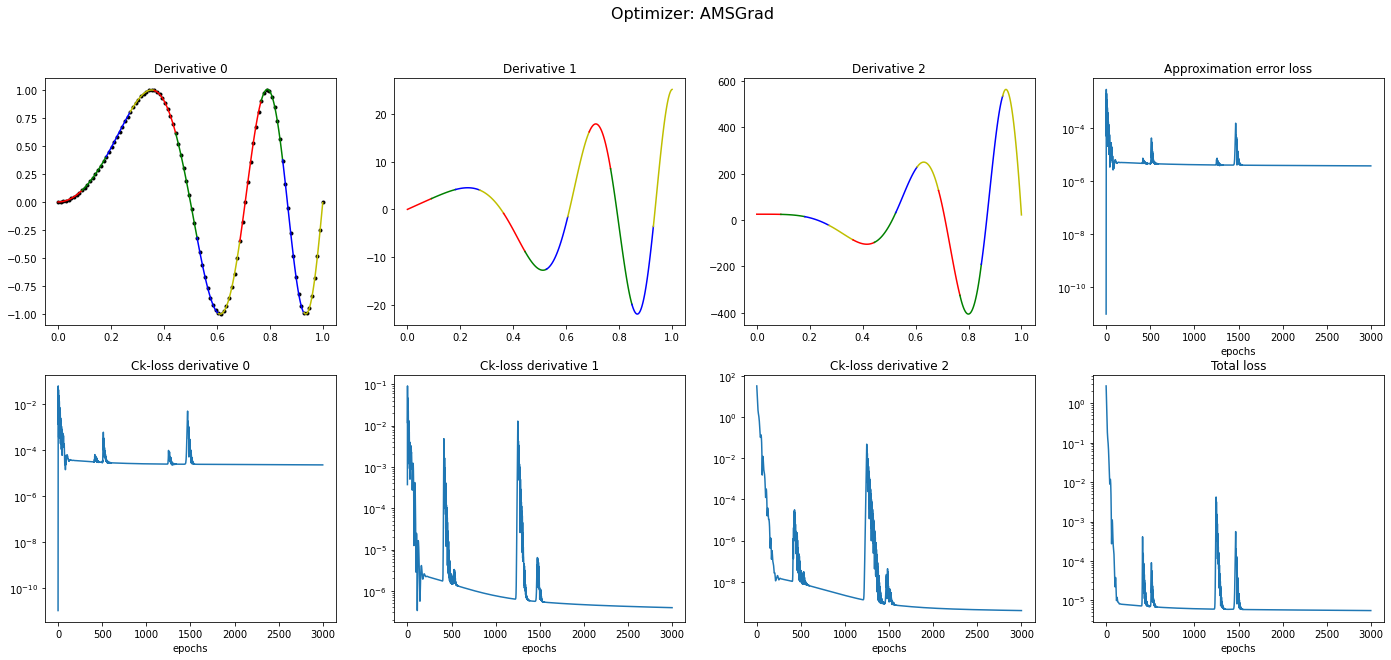

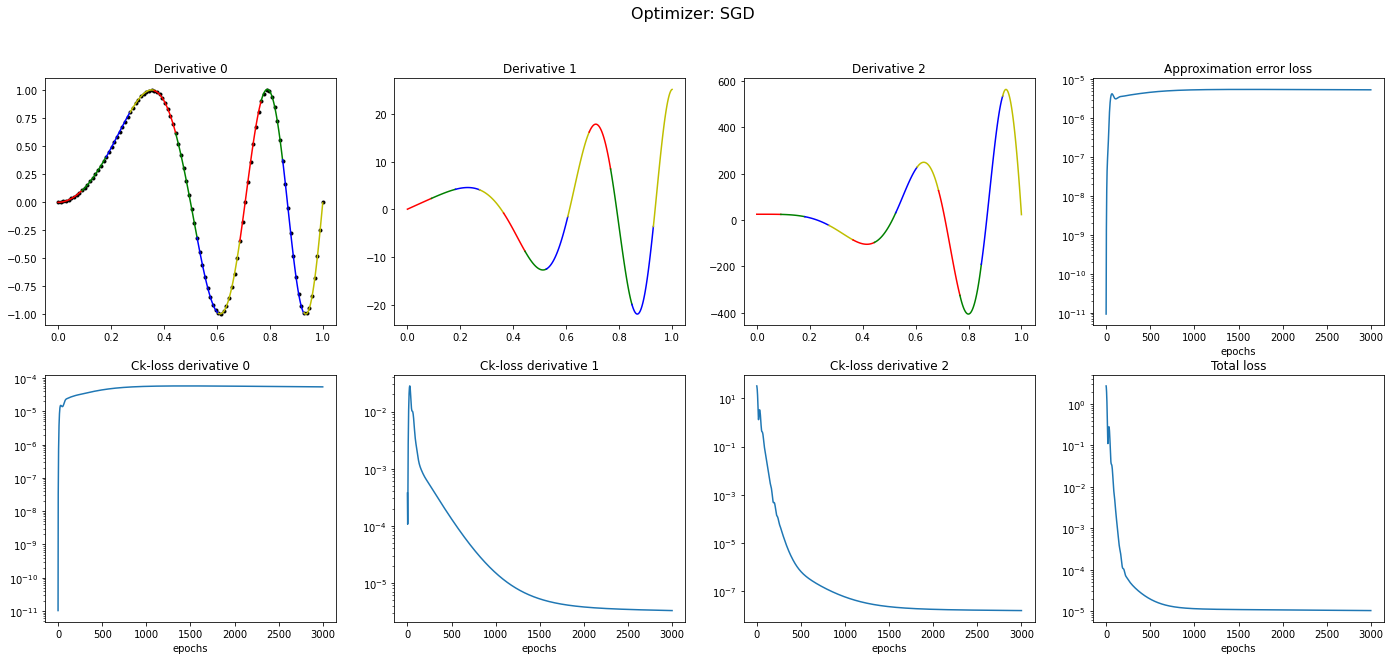

In [6]:
# Plot without derivative specific Ck-Loss
# fig, axes = plt.subplots(1, 4)
# fig.set_figwidth(24)
# fig.set_figheight(5)
# ep = np.linspace(0, epochs, epochs)

# fig.suptitle('Optimizer: AMSGrad', fontsize=16)
# axes[0].plot(data_x, data_y, '.', color="black")
# plot.plot_spline(spline_adam, plot_input=False, deriv=0, plot_max_h_lines=False, segment_resolution = 100, ax=axes[0])
# axes[0].set_title('Derivative 0')
# plot.plot_spline(spline_adam, plot_input=False, deriv=1, plot_max_h_lines=False, segment_resolution = 100, ax=axes[1])
# axes[1].set_title('Derivative 1')
# plot.plot_spline(spline_adam, plot_input=False, deriv=2, plot_max_h_lines=False, segment_resolution = 100, ax=axes[2])
# axes[2].set_title('Derivative 2')
# plot.plot_loss(spline_adam, type='total', ax=axes[3])
# axes[3].set_title('Total Loss')

# fig, axes = plt.subplots(1, 4)
# fig.set_figwidth(24)
# fig.set_figheight(5)
# ep = np.linspace(0, epochs, epochs)

# fig.suptitle('Optimizer: SGD', fontsize=16)
# axes[0].plot(data_x, data_y, '.', color="black")
# plot.plot_spline(spline_sgd, plot_input=False, deriv=0, plot_max_h_lines=False, segment_resolution = 100, ax=axes[0])
# axes[0].set_title('Derivative 0')
# plot.plot_spline(spline_sgd, plot_input=False, deriv=1, plot_max_h_lines=False, segment_resolution = 100, ax=axes[1])
# axes[1].set_title('Derivative 1')
# plot.plot_spline(spline_sgd, plot_input=False, deriv=2, plot_max_h_lines=False, segment_resolution = 100, ax=axes[2])
# axes[2].set_title('Derivative 2')
# plot.plot_loss(spline_sgd, type='total', ax=axes[3])
# axes[3].set_title('Total Loss')

# Plot with derivative specific Ck-Loss
fig, axes = plt.subplots(2, 4)
fig.set_figwidth(24)
fig.set_figheight(10)
ep = np.linspace(0, epochs, epochs)

ck0 = [row[0] for row in spline_adam.d_loss_values]
ck1 = [row[1] for row in spline_adam.d_loss_values]
ck2 = [row[2] for row in spline_adam.d_loss_values]

fig.suptitle('Optimizer: AMSGrad', fontsize=16)
axes[0,0].plot(data_x, data_y, '.', color="black")
plot.plot_spline(spline_adam, plot_input=False, deriv=0, plot_max_h_lines=False, segment_resolution = 100, ax=axes[0,0])
axes[0,0].set_title('Derivative 0')
plot.plot_spline(spline_adam, plot_input=False, deriv=1, plot_max_h_lines=False, segment_resolution = 100, ax=axes[0,1])
axes[0,1].set_title('Derivative 1')
plot.plot_spline(spline_adam, plot_input=False, deriv=2, plot_max_h_lines=False, segment_resolution = 100, ax=axes[0,2])
axes[0,2].set_title('Derivative 2')
axes[0,3].semilogy(spline_adam.e_loss_values)
axes[0,3].set_title('Approximation error loss')
axes[0,3].set_xlabel('epochs')
axes[1,0].semilogy(np.linspace(0, 3000, 3000), ck0)
axes[1,0].set_title('Ck-loss derivative 0')
axes[1,0].set_xlabel('epochs')
axes[1,1].semilogy(np.linspace(0, 3000, 3000), ck1)
axes[1,1].set_title('Ck-loss derivative 1')
axes[1,1].set_xlabel('epochs')
axes[1,2].semilogy(np.linspace(0, 3000, 3000), ck2)
axes[1,2].set_title('Ck-loss derivative 2')
axes[1,2].set_xlabel('epochs')
axes[1,3].semilogy(spline_adam.total_loss_values)
axes[1,3].set_title('Total loss')
axes[1,3].set_xlabel('epochs')

ck0 = [row[0] for row in spline_sgd.d_loss_values]
ck1 = [row[1] for row in spline_sgd.d_loss_values]
ck2 = [row[2] for row in spline_sgd.d_loss_values]

fig, axes = plt.subplots(2, 4)
fig.set_figwidth(24)
fig.set_figheight(10)
ep = np.linspace(0, epochs, epochs)

fig.suptitle('Optimizer: SGD', fontsize=16)
axes[0,0].plot(data_x, data_y, '.', color="black")
plot.plot_spline(spline_sgd, plot_input=False, deriv=0, plot_max_h_lines=False, segment_resolution = 100, ax=axes[0,0])
axes[0,0].set_title('Derivative 0')
plot.plot_spline(spline_sgd, plot_input=False, deriv=1, plot_max_h_lines=False, segment_resolution = 100, ax=axes[0,1])
axes[0,1].set_title('Derivative 1')
plot.plot_spline(spline_sgd, plot_input=False, deriv=2, plot_max_h_lines=False, segment_resolution = 100, ax=axes[0,2])
axes[0,2].set_title('Derivative 2')
axes[0,3].semilogy(spline_sgd.e_loss_values)
axes[0,3].set_title('Approximation error loss')
axes[0,3].set_xlabel('epochs')
axes[1,0].semilogy(np.linspace(0, 3000, 3000), ck0)
axes[1,0].set_title('Ck-loss derivative 0')
axes[1,0].set_xlabel('epochs')
axes[1,1].semilogy(np.linspace(0, 3000, 3000), ck1)
axes[1,1].set_title('Ck-loss derivative 1')
axes[1,1].set_xlabel('epochs')
axes[1,2].semilogy(np.linspace(0, 3000, 3000), ck2)
axes[1,2].set_title('Ck-loss derivative 2')
axes[1,2].set_xlabel('epochs')
axes[1,3].semilogy(spline_sgd.total_loss_values)
axes[1,3].set_title('Total loss')
axes[1,3].set_xlabel('epochs')

### Sweep parameters

In this experiment, we iterate $\lambda_1$ from $0$ to $1$ and $\lambda_2$ from $1$ to $0$ and observe the convergence behavior using Adam and SDG optimizers.

In [7]:
kwargs = {'data_x': data_x, 'data_y': data_y, 'learning_rate': learning_rate_adam, 'degree': deg, 'polynum': n, 'continuity': continuity, 
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 'gradient_regularization': gradient_regularization, 'mode': 'approx_ck'}

#params = np.linspace(0.01, 0.99, 10, endpoint=True)
params = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.99]

pool = mp.Pool(mp.cpu_count())
results_adam = pool.starmap(parallel.job, zip(params, repeat(kwargs)))

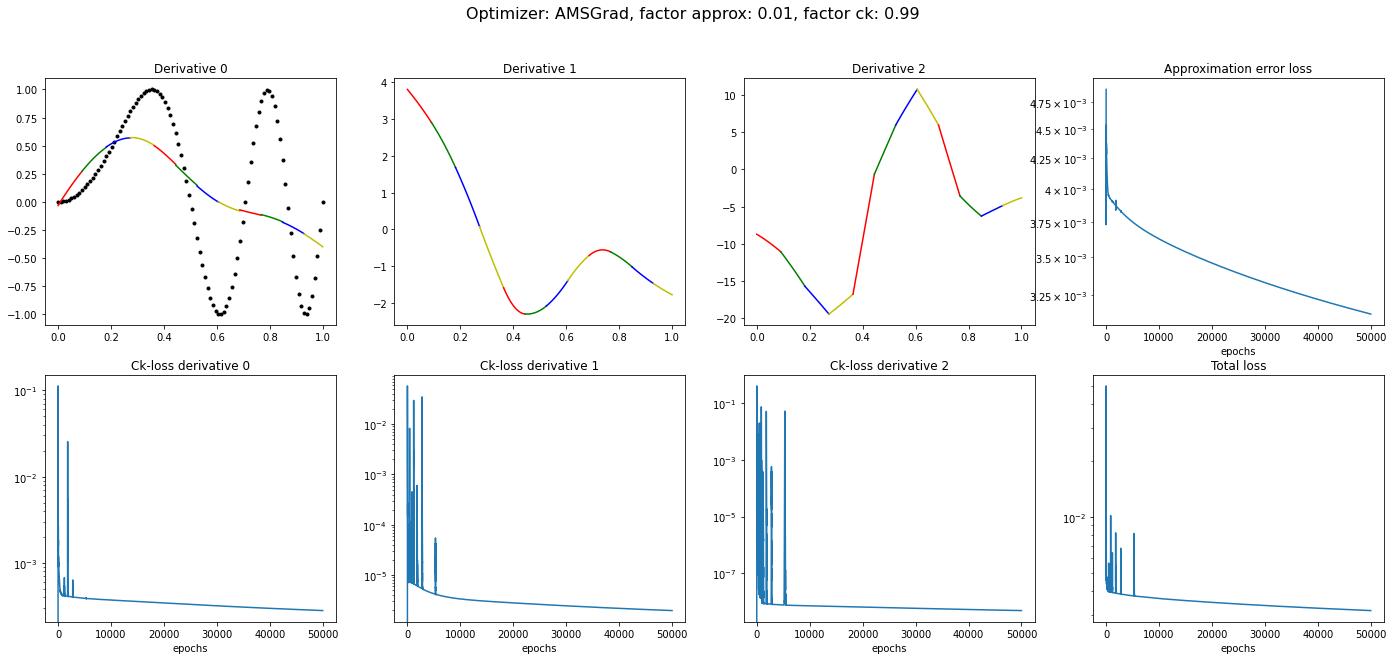

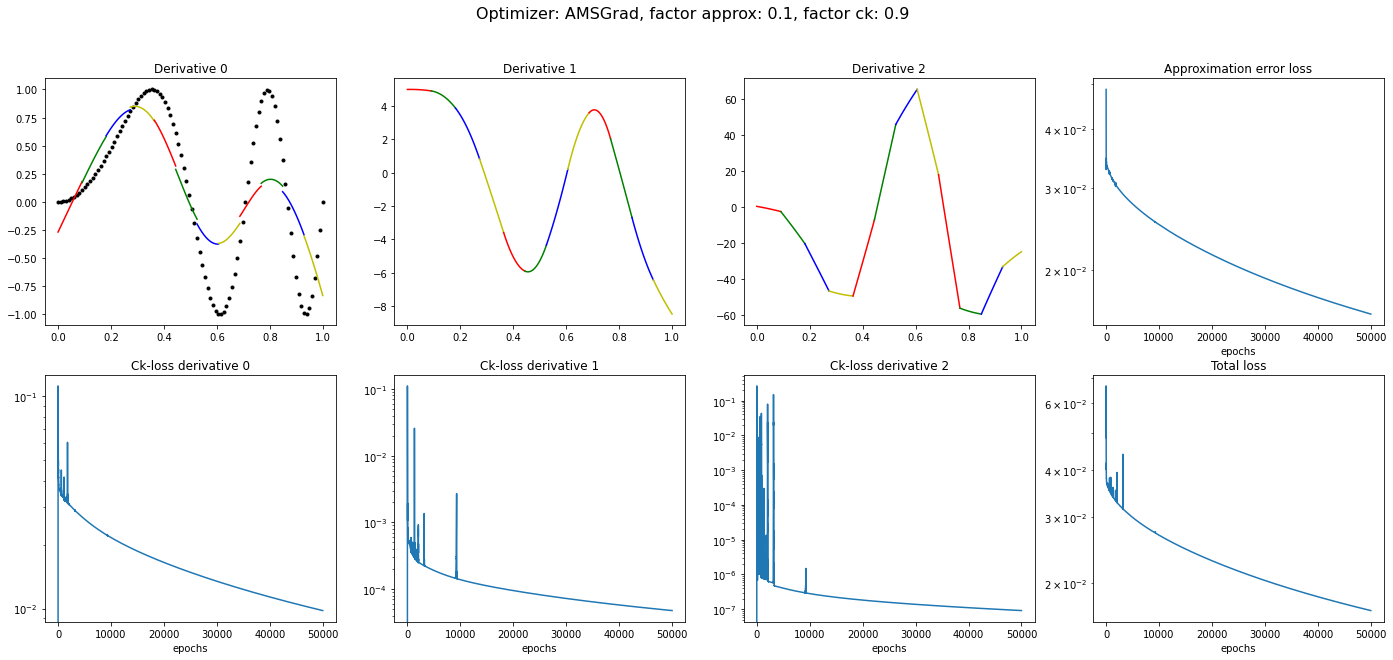

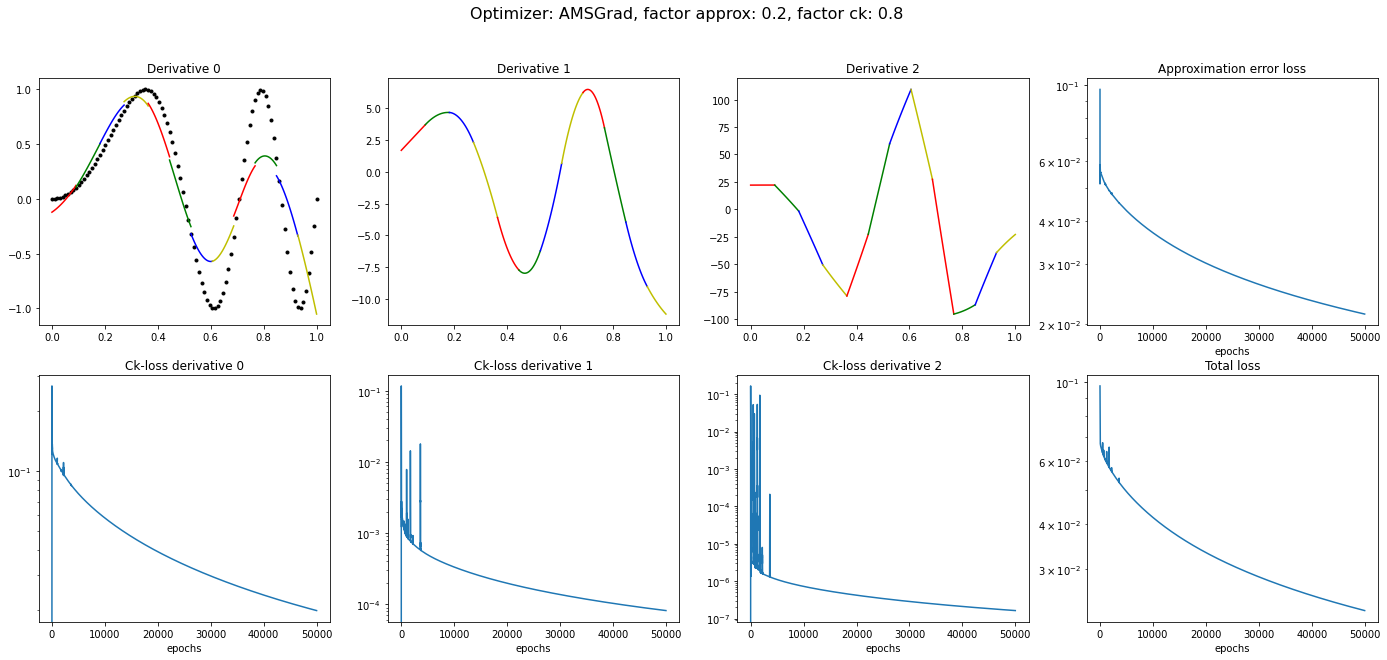

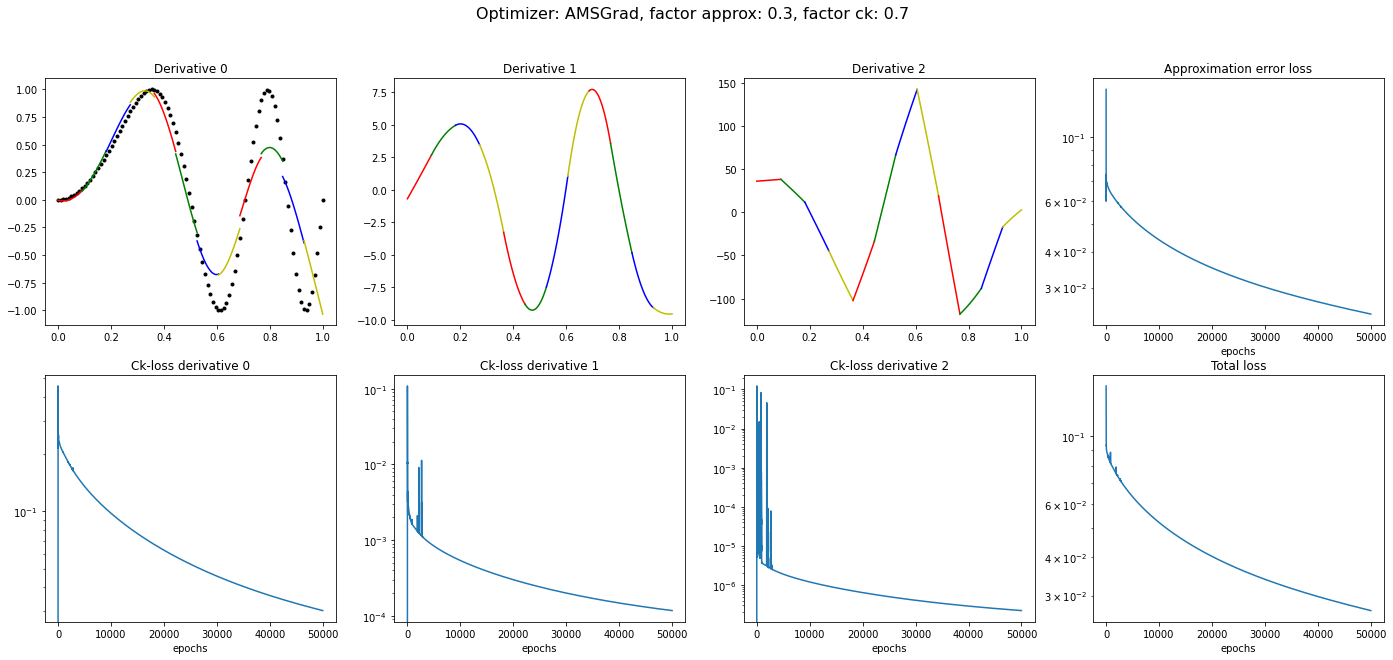

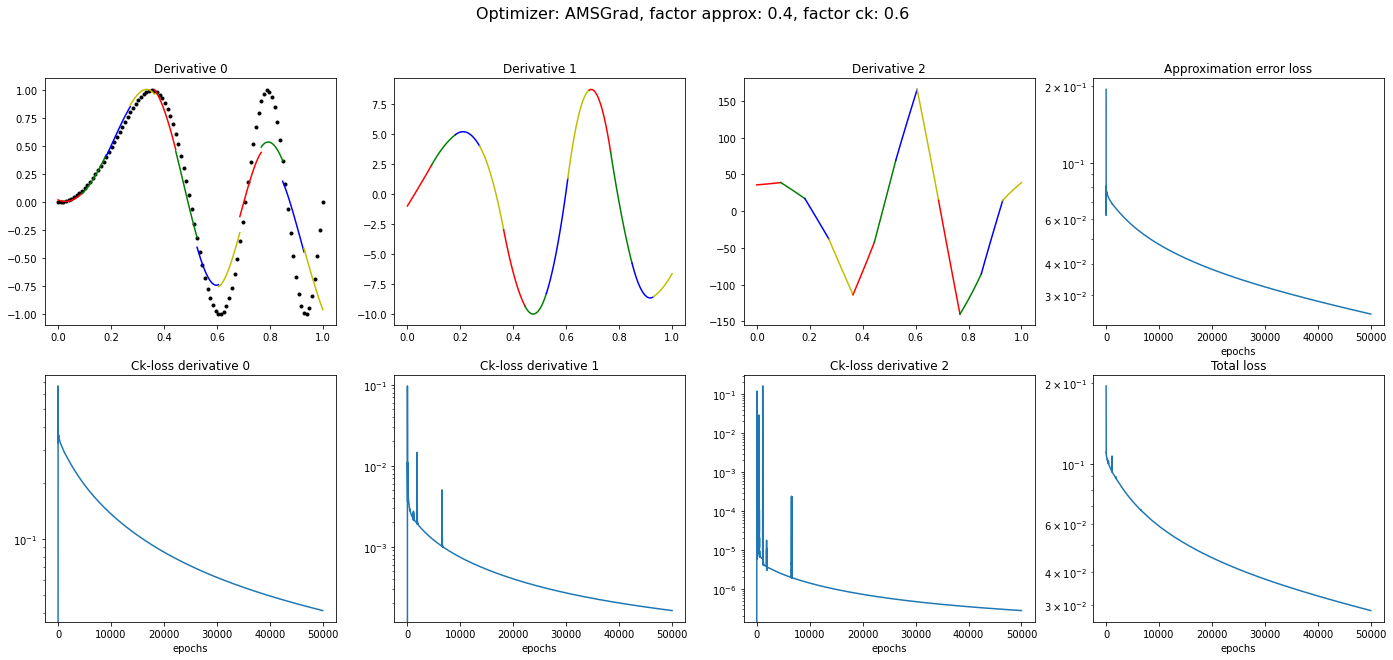

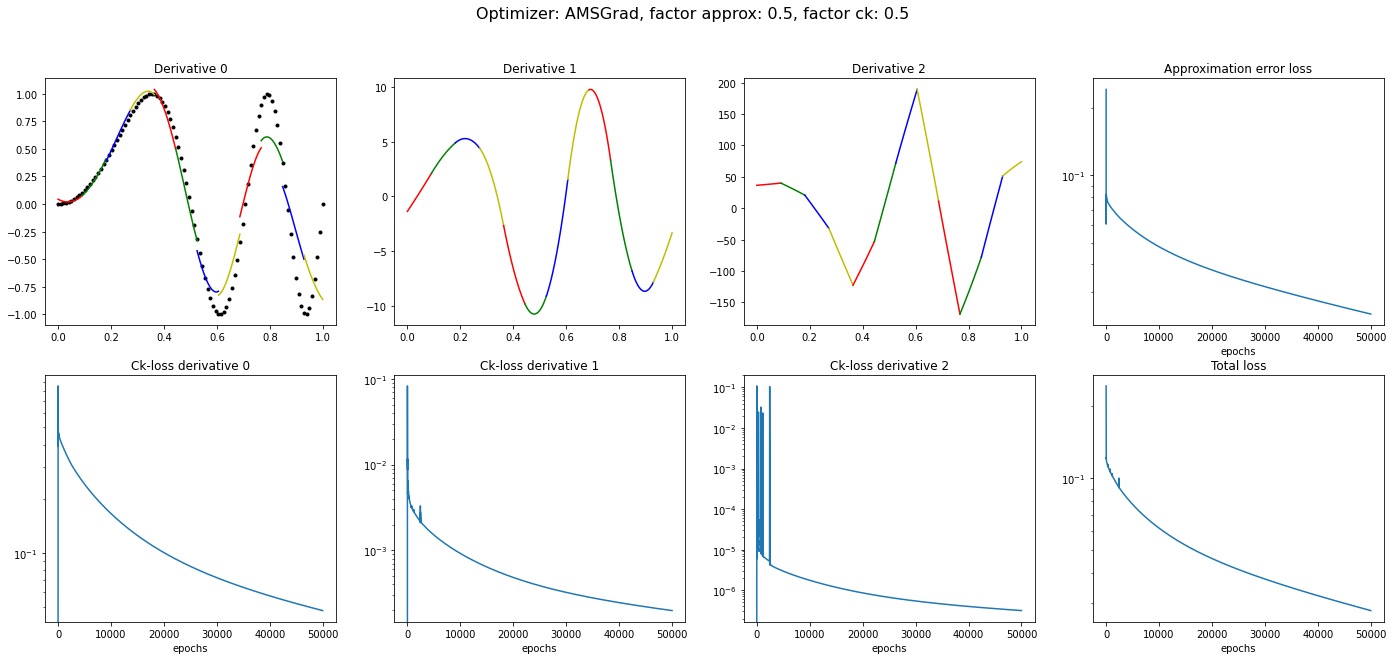

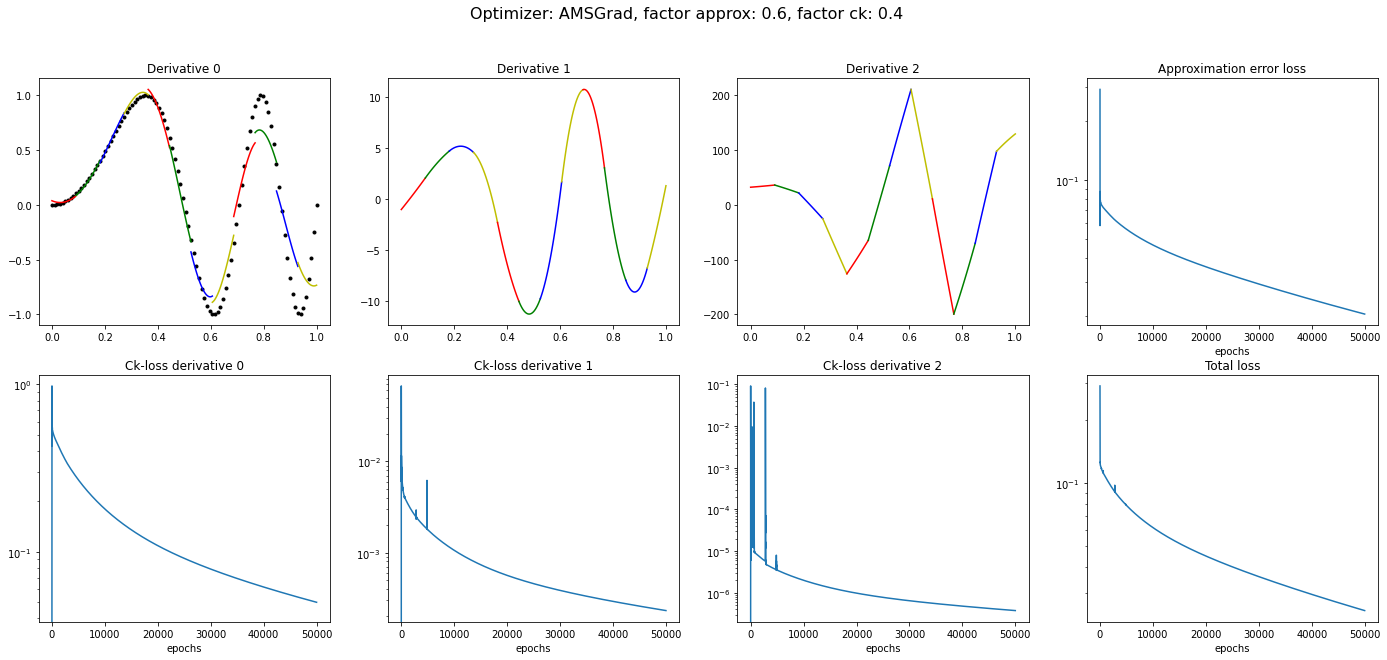

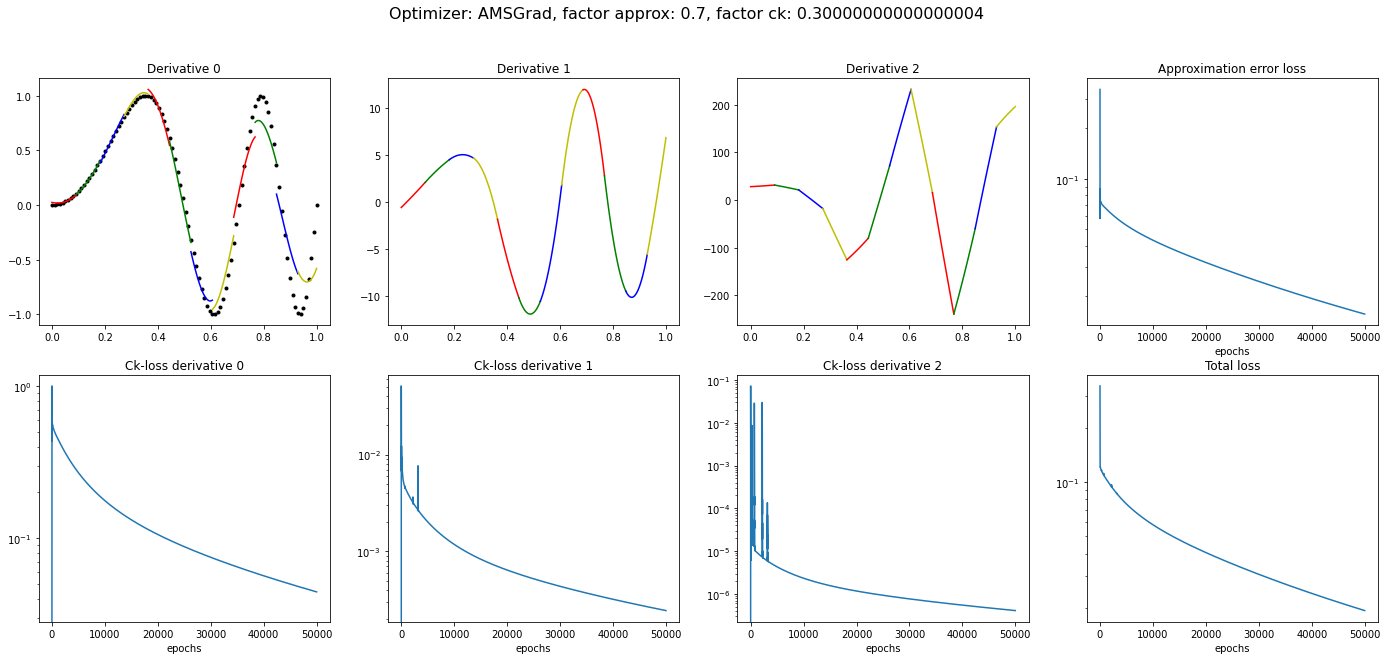

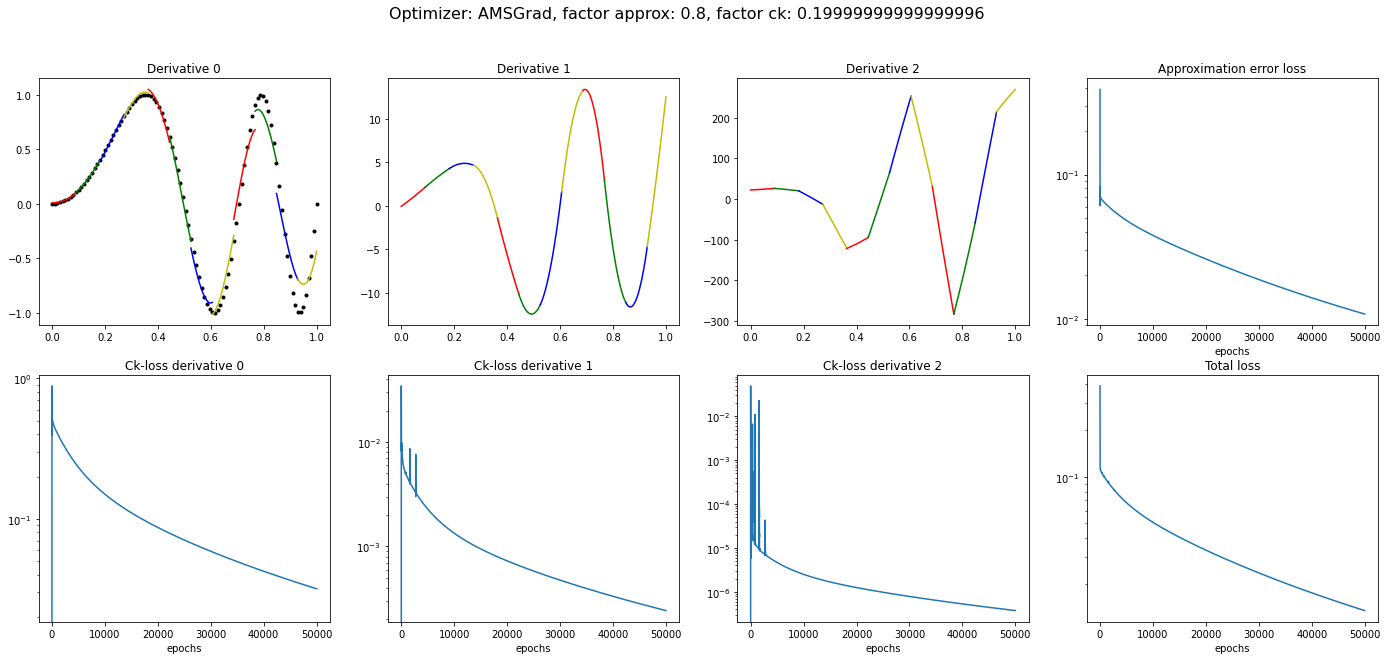

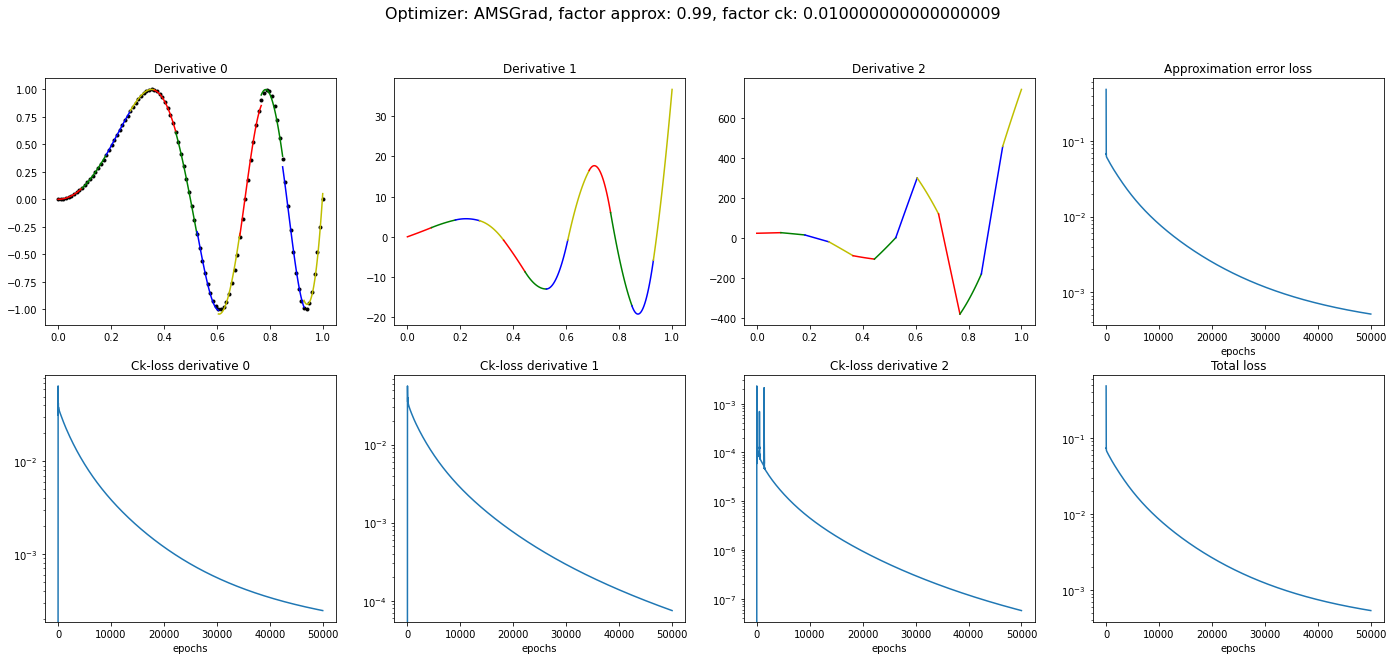

In [8]:
# Plot without derivative specific Ck-Loss
# for i in range(len(params)):
#     fig, axes = plt.subplots(1, 4)
#     fig.set_figwidth(24)
#     fig.set_figheight(5)
#     ep = np.linspace(0, epochs, epochs)

#     spline = model.get_spline_from_coeffs(results_adam[i][2], data_x, data_y)

#     fig.suptitle('Optimizer: ' + results_adam[i][0]['optimizer'] + ', factor approx: ' + str(results_adam[i][0]['param_value']) + ', factor ck: ' + str(1 - results_adam[i][0]['param_value']), fontsize=16)
#     axes[0].plot(data_x, data_y, '.', color="black")
#     plot.plot_spline(spline, plot_input=False, deriv=0, plot_max_h_lines=False, segment_resolution = 100, ax=axes[0])
#     axes[0].set_title('Derivative 0')
#     plot.plot_spline(spline, plot_input=False, deriv=1, plot_max_h_lines=False, segment_resolution = 100, ax=axes[1])
#     axes[1].set_title('Derivative 1')
#     plot.plot_spline(spline, plot_input=False, deriv=2, plot_max_h_lines=False, segment_resolution = 100, ax=axes[2])
#     axes[2].set_title('Derivative 2')
#     axes[3].semilogy(results_adam[i][1][0])
#     axes[3].set_title('Total loss')
#     axes[3].set_xlabel('epochs')

# Plot with derivative specific Ck-Loss
for i in range(len(params)):
    fig, axes = plt.subplots(2, 4)
    fig.set_figwidth(24)
    fig.set_figheight(10)
    ep = np.linspace(0, epochs, epochs)

    spline = model.get_spline_from_coeffs(results_adam[i][2], data_x, data_y)
    ck0 = [row[0] for row in results_adam[i][1][2]]
    ck1 = [row[1] for row in results_adam[i][1][2]]
    ck2 = [row[2] for row in results_adam[i][1][2]]

    fig.suptitle('Optimizer: ' + results_adam[i][0]['optimizer'] + ', factor approx: ' + str(results_adam[i][0]['param_value']) + ', factor ck: ' + str(1 - results_adam[i][0]['param_value']), fontsize=16)
    axes[0,0].plot(data_x, data_y, '.', color="black")
    plot.plot_spline(spline, plot_input=False, deriv=0, plot_max_h_lines=False, segment_resolution = 100, ax=axes[0,0])
    axes[0,0].set_title('Derivative 0')
    plot.plot_spline(spline, plot_input=False, deriv=1, plot_max_h_lines=False, segment_resolution = 100, ax=axes[0,1])
    axes[0,1].set_title('Derivative 1')
    plot.plot_spline(spline, plot_input=False, deriv=2, plot_max_h_lines=False, segment_resolution = 100, ax=axes[0,2])
    axes[0,2].set_title('Derivative 2')
    axes[0,3].semilogy(results_adam[i][1][1])
    axes[0,3].set_title('Approximation error loss')
    axes[0,3].set_xlabel('epochs')
    axes[1,0].semilogy(np.linspace(0, epochs, epochs), ck0)
    axes[1,0].set_title('Ck-loss derivative 0')
    axes[1,0].set_xlabel('epochs')
    axes[1,1].semilogy(np.linspace(0, epochs, epochs), ck1)
    axes[1,1].set_title('Ck-loss derivative 1')
    axes[1,1].set_xlabel('epochs')
    axes[1,2].semilogy(np.linspace(0, epochs, epochs), ck2)
    axes[1,2].set_title('Ck-loss derivative 2')
    axes[1,2].set_xlabel('epochs')
    axes[1,3].semilogy(results_adam[i][1][0])
    axes[1,3].set_title('Total loss')
    axes[1,3].set_xlabel('epochs')

Text(0.5, 1.0, 'Optimizer AMSGrad: total loss over epoch for different lambdas')

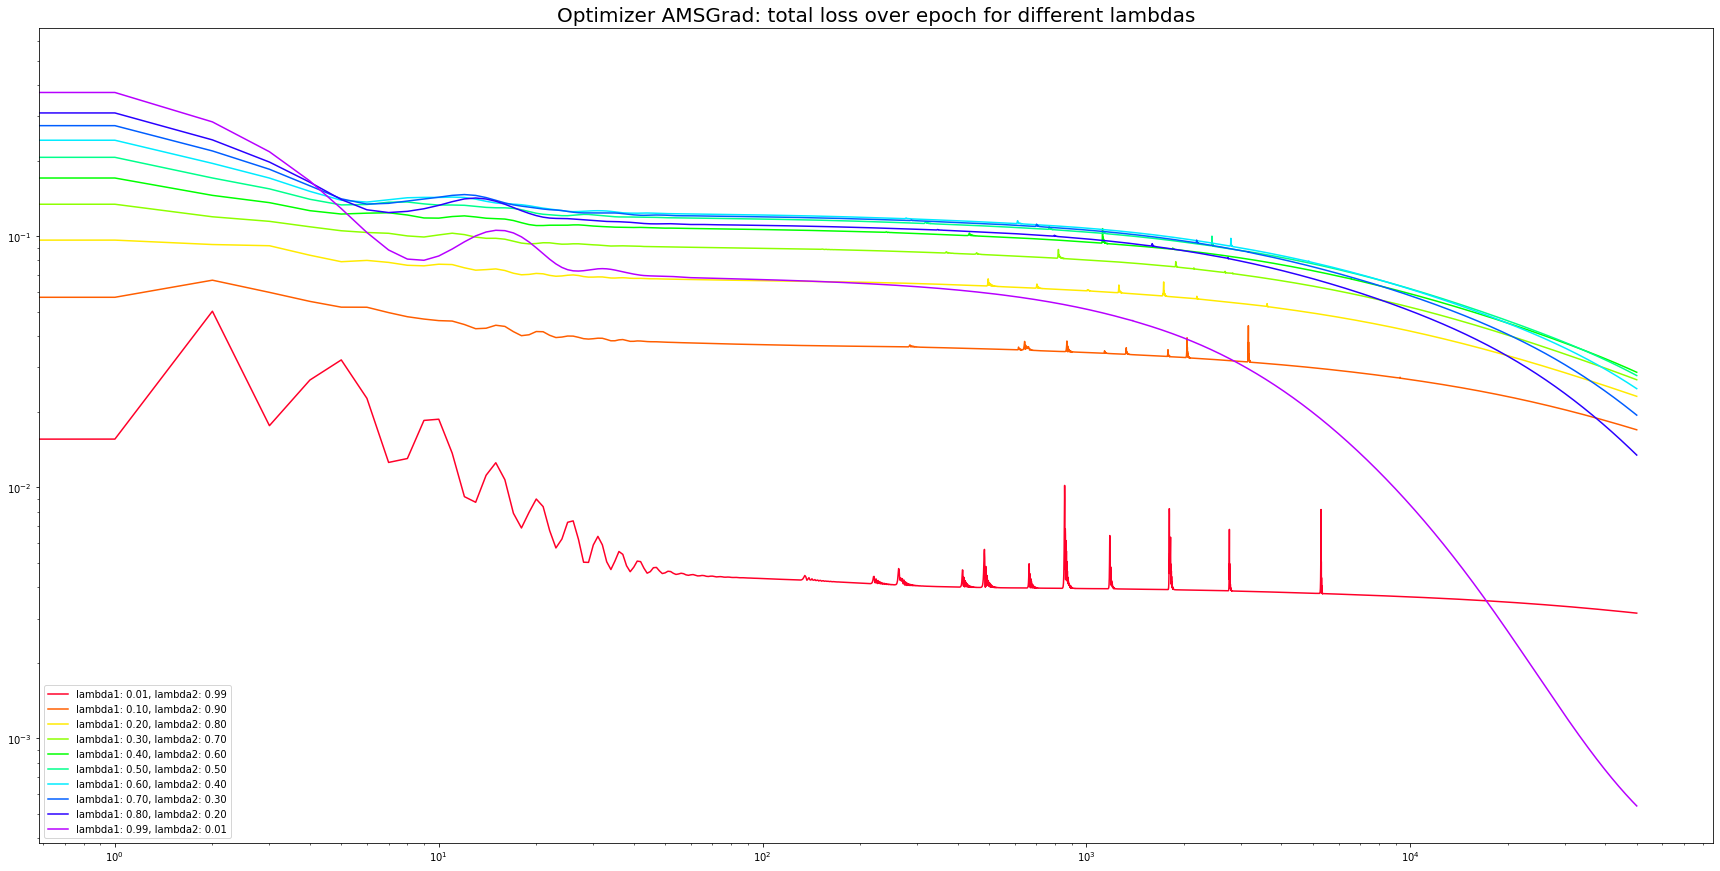

In [9]:
labels = []

NUM_COLORS = len(params)

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i in range(len(params)):
    labels.append('lambda1: ' + "{:.2f}".format(params[i]) + ', lambda2: ' + "{:.2f}".format(1 - params[i]))

for i in range(len(params)):
    ax.semilogy(results_adam[i][1][0])

legend = plt.legend(labels, loc='lower left')
plt.xscale('log') 
plt.title('Optimizer AMSGrad: total loss over epoch for different lambdas', fontdict = {'fontsize' : 20})